In [2]:
pip install -qq git+https://www.github.com/keras-team/keras-contrib.git

Note: you may need to restart the kernel to use updated packages.


In [3]:
from IPython.display import clear_output
import scipy
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.io import imread
import os
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm_notebook
clear_output()

In [4]:
!ls ../input/chest-xray-masks-and-labels/data/Lung\ Segmentation

CXR_png		  NLM-ChinaCXRSet-ReadMe.docx	   masks
ClinicalReadings  NLM-MontgomeryCXRSet-ReadMe.pdf  test


In [5]:
base_path = Path('..') / 'input' / 'chest-xray-masks-and-labels'
all_images_df = pd.DataFrame({'path': list(base_path.glob('**/*.*p*g'))})
all_images_df.sample(3)

,path
3185,../input/chest-xray-masks-and-labels/Lung Segm...
325,../input/chest-xray-masks-and-labels/data/Lung...
2576,../input/chest-xray-masks-and-labels/Lung Segm...


In [6]:
all_images_df['modality'] = all_images_df['path'].map(lambda x: x.parent.stem)
all_images_df['source'] = all_images_df['path'].map(lambda x: x.stem.split('_')[0])
all_images_df['image_id'] = all_images_df['path'].map(lambda x: '_'.join(x.stem.split('_')[1:2]))
all_images_df = all_images_df[all_images_df['modality'].isin(['masks', 'CXR_png'])]
print(all_images_df['modality'].value_counts())
all_images_df.sample(3)

CXR_png    1600
masks      1408
Name: modality, dtype: int64


,path,modality,source,image_id
573,../input/chest-xray-masks-and-labels/data/Lung...,CXR_png,CHNCXR,0455
2597,../input/chest-xray-masks-and-labels/Lung Segm...,masks,CHNCXR,0263
1824,../input/chest-xray-masks-and-labels/Lung Segm...,CXR_png,CHNCXR,0236


In [7]:
all_images_df['path'].values[:4]

array([PosixPath('../input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/CHNCXR_0092_0.png'),
       PosixPath('../input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/CHNCXR_0322_0.png'),
       PosixPath('../input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/CHNCXR_0304_0.png'),
       PosixPath('../input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/CHNCXR_0572_1.png')],
      dtype=object)

In [8]:
flat_images_df = all_images_df.pivot_table(index=['source', 'image_id'], 
                          columns='modality', 
                          values='path', 
                          aggfunc='first').\
    reset_index().\
    sort_values('image_id').\
    dropna()
print(flat_images_df.shape[0])
flat_images_df.sample(3)

704


modality,source,image_id,CXR_png,masks
766,MCUCXR,0243,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
314,CHNCXR,0315,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
226,CHNCXR,0227,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...


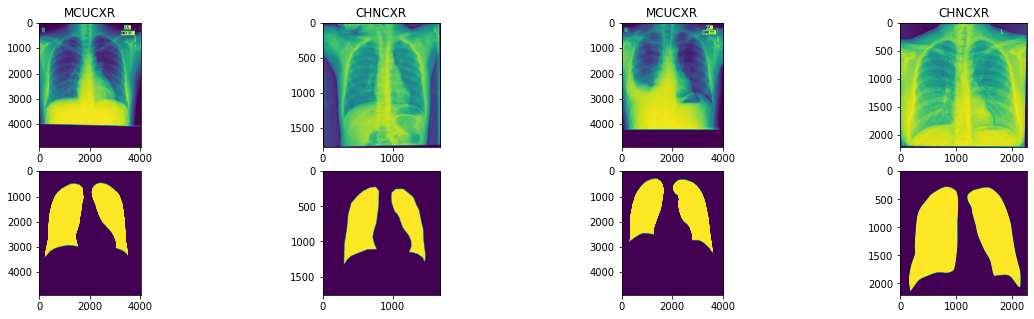

In [9]:
fig, (a_axs, b_axs) = plt.subplots(2, 4, figsize=(20, 5))
for a_ax, b_ax, (_, c_row) in  zip(a_axs, b_axs, flat_images_df.sample(20).iterrows()):
    a_img = imread(c_row['CXR_png'])
    a_ax.imshow(a_img)
    a_ax.set_title(c_row['source'])
    b_img = imread(c_row['masks'])
    b_ax.imshow(b_img)

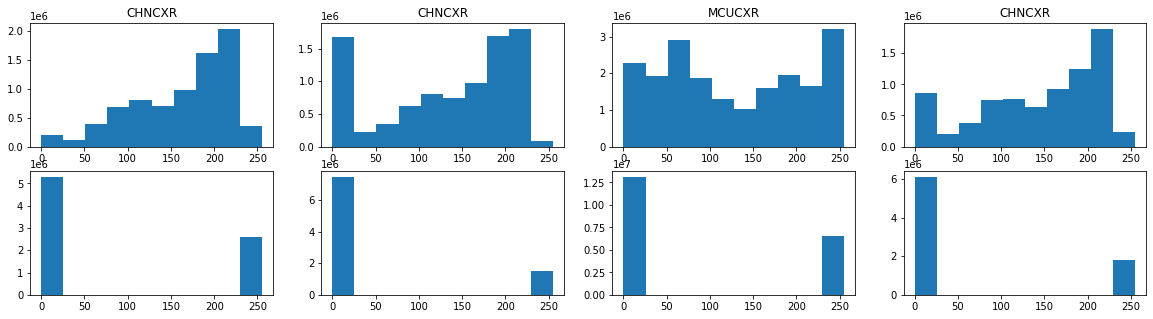

In [10]:
fig, (a_axs, b_axs) = plt.subplots(2, 4, figsize=(20, 5))
for a_ax, b_ax, (_, c_row) in  zip(a_axs, b_axs, flat_images_df.sample(20).iterrows()):
    a_img = imread(c_row['CXR_png'])
    a_ax.hist(a_img.ravel())
    a_ax.set_title(c_row['source'])
    b_img = imread(c_row['masks'])
    b_ax.hist(b_img.ravel())

In [11]:
#all_images_df = all_images_df.sample(4096)
images_a_df = all_images_df[all_images_df['modality']=='CXR_png'].copy()
images_a_df['image_path'] = images_a_df['path'].map(str)
images_b_df = all_images_df[all_images_df['modality']=='masks'].copy()
images_b_df['image_path'] = images_b_df['path'].map(str)

In [21]:
from tensorflow.keras.optimizers import Adam

In [22]:
class CycleGAN():
    def __init__(self,
                 img_rows,
                 img_cols,
                 channels_A,
                 channels_B,
                 parallel_channels=True,
                 ):
        """
        args:
          parallel_channels: process each input and output channel on its own
        """
        # Input shape
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels_A = channels_A
        self.channels_B = channels_B
        self.parallel_channels = parallel_channels
        self.img_shape_A = (self.img_rows, self.img_cols, self.channels_A)
        self.img_shape_B = (self.img_rows, self.img_cols, self.channels_B)
        # Calculate output shape of D (PatchGAN)
        patch_r = int(self.img_rows / 2**4)
        patch_c = int(self.img_cols / 2**4)
        self.disc_patch = (patch_r, patch_c, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator(self.img_shape_A, suffix='A')
        self.d_B = self.build_discriminator(self.img_shape_B, suffix='B')
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
          # Build the generators
        self.g_AB = self.build_generator(
            self.img_shape_A, self.img_shape_B, suffix='AB')
        self.g_BA = self.build_generator(
            self.img_shape_B, self.img_shape_A, suffix='BA')

        # Input images from both domains
        img_A = Input(shape=self.img_shape_A, name='ImageA')
        img_B = Input(shape=self.img_shape_B, name='ImageB')

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_B)
        img_B_id = self.g_AB(img_A)
         # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

    def build_generator(self, in_img_shape, out_img_shape, suffix=''):
        """U-Net Generator"""
        in_chan = in_img_shape[-1]
        out_chan = out_img_shape[-1]
        gf_down = self.gf // in_chan if self.parallel_channels else self.gf
        gf_up = self.gf // in_chan if self.parallel_channels else self.gf

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size,
                       strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d
        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1,
                       padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=in_img_shape)
        # Downsampling

        def _ds_pipe(in_d0):
            d1 = conv2d(in_d0, gf_down)
            d2 = conv2d(d1, gf_down*2)
            d3 = conv2d(d2, gf_down*4)
            d4 = conv2d(d3, gf_down*8)
            return d1, d2, d3, d4
        if (in_chan > 1) and self.parallel_channels:
            chan_list = []
            for i in range(in_chan):
                c_d0 = layers.Lambda(
                    lambda x: x[:, :, :, i:(i+1)],
                    name='InSel{}_{}'.format(suffix, i))(d0)
                chan_list.append(_ds_pipe(c_d0))
            d1, d2, d3, d4 = [
                layers.concatenate(list(c_outs))
                for c_outs in zip(*chan_list)]
        else:
            d1, d2, d3, d4 = _ds_pipe(d0)

        # Upsampling
        def _us_pipe(chan_count, d1, d2, d3, d4):
            u1 = deconv2d(d4, d3, gf_up*4)
            u2 = deconv2d(u1, d2, gf_up*2)
            u3 = deconv2d(u2, d1, gf_up)

            u4 = UpSampling2D(size=2)(u3)
            output_img = Conv2D(chan_count, kernel_size=4, strides=1,
                            padding='same', activation='sigmoid')(u4)
            return output_img
        if (out_chan > 1) and self.parallel_channels:
            chan_list = []
            for i in range(out_chan):
                chan_list.append(_us_pipe(1, d1, d2, d3, d4))
            output_img = layers.concatenate(chan_list)
        else:
            output_img = _us_pipe(out_chan, d1, d2, d3, d4)
        

        return Model(d0, output_img, name='Gen{}_{}_{}_{}-{}'.format(suffix, *in_img_shape, out_img_shape[-1]))

    def build_discriminator(self, img_shape, suffix=''):
        in_chan = img_shape[-1]
        df = self.df // in_chan if self.parallel_channels else self.df

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size,
                       strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d
        img = Input(shape=img_shape)

        def _disc_block(in_img):
            d1 = d_layer(in_img, df, normalization=False)
            d2 = d_layer(d1, df*2)
            d3 = d_layer(d2, df*4)
            d4 = d_layer(d3, df*8)
            return d4

        if (in_chan > 1) or not self.parallel_channels:
            chan_list = []
            for i in range(in_chan):
                c_img = layers.Lambda(
                    lambda x: x[:, :, :, i:(i+1)],
                    name='DiscSelect{}_{}'.format(suffix, i))(img)
                chan_list.append(_disc_block(c_img))
            d4 = layers.concatenate(chan_list)
        else:
            d4 = _disc_block(img)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity, name='Disc{}_{}_{}_{}'.format(suffix, *img_shape))

In [23]:
IMAGE_SIZE = 128, 128
IMAGE_A_CHANNELS = 1 # X-ray
IMAGE_B_CHANNELS = 1 # Segmentation

In [24]:
cg = CycleGAN(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_A_CHANNELS, IMAGE_B_CHANNELS)

2022-01-21 07:04:03.569269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 07:04:03.686541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 07:04:03.687277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 07:04:03.688487: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

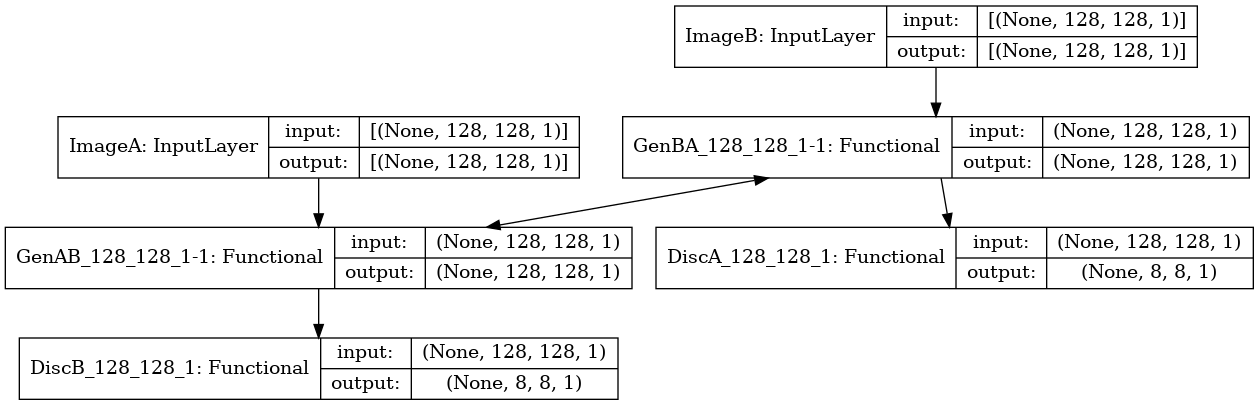

In [25]:
Image(model_to_dot(cg.combined, show_shapes=True).create_png())

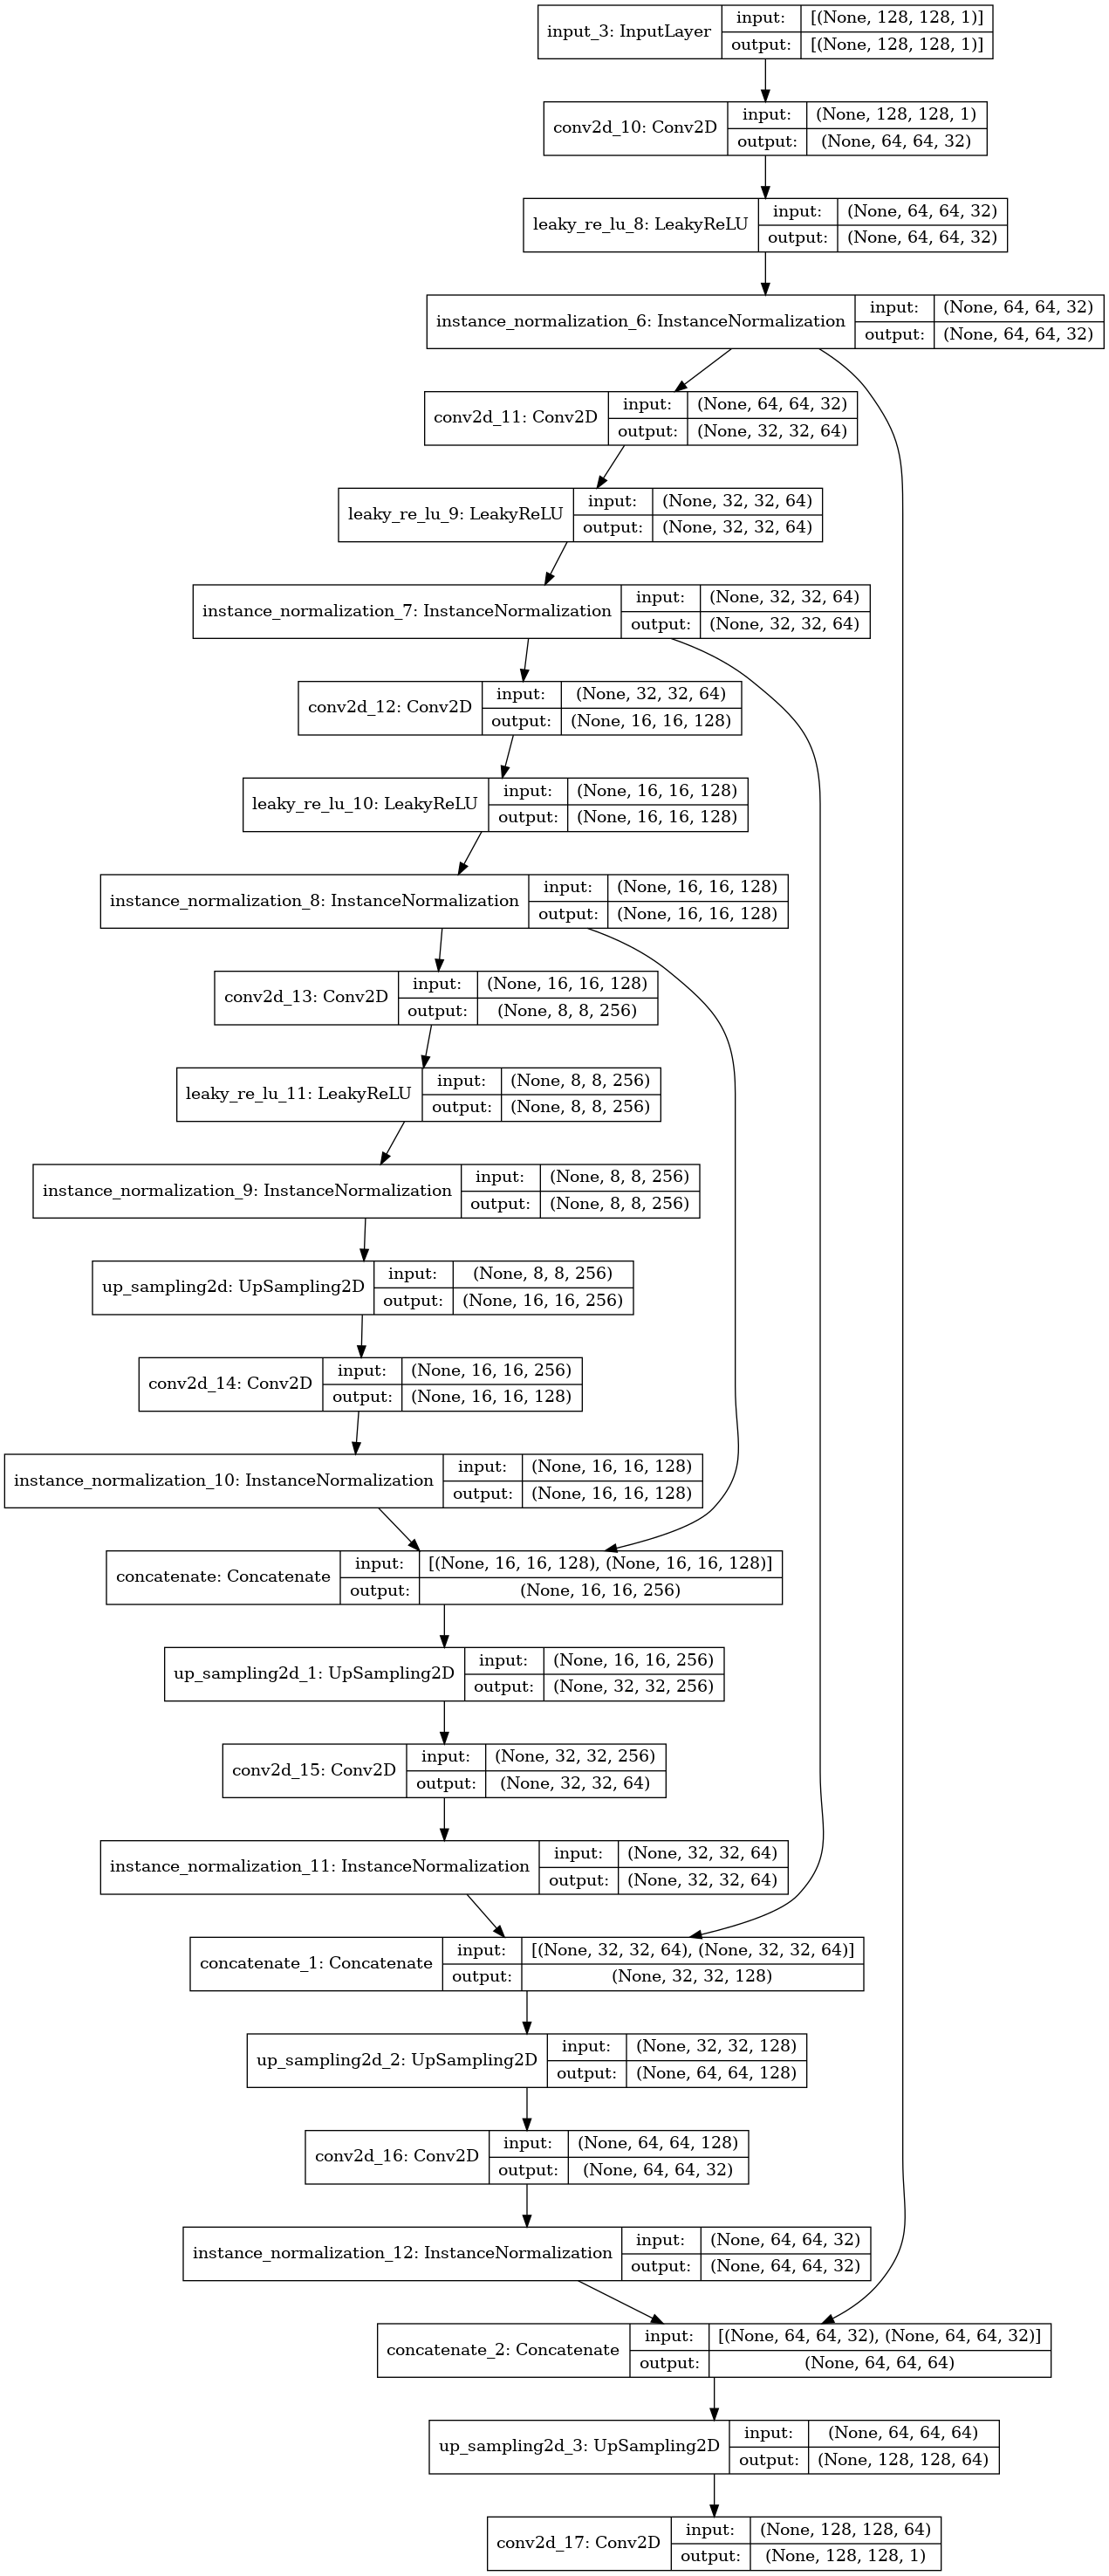

In [26]:
Image(model_to_dot(cg.g_AB, show_shapes=True).create_png())

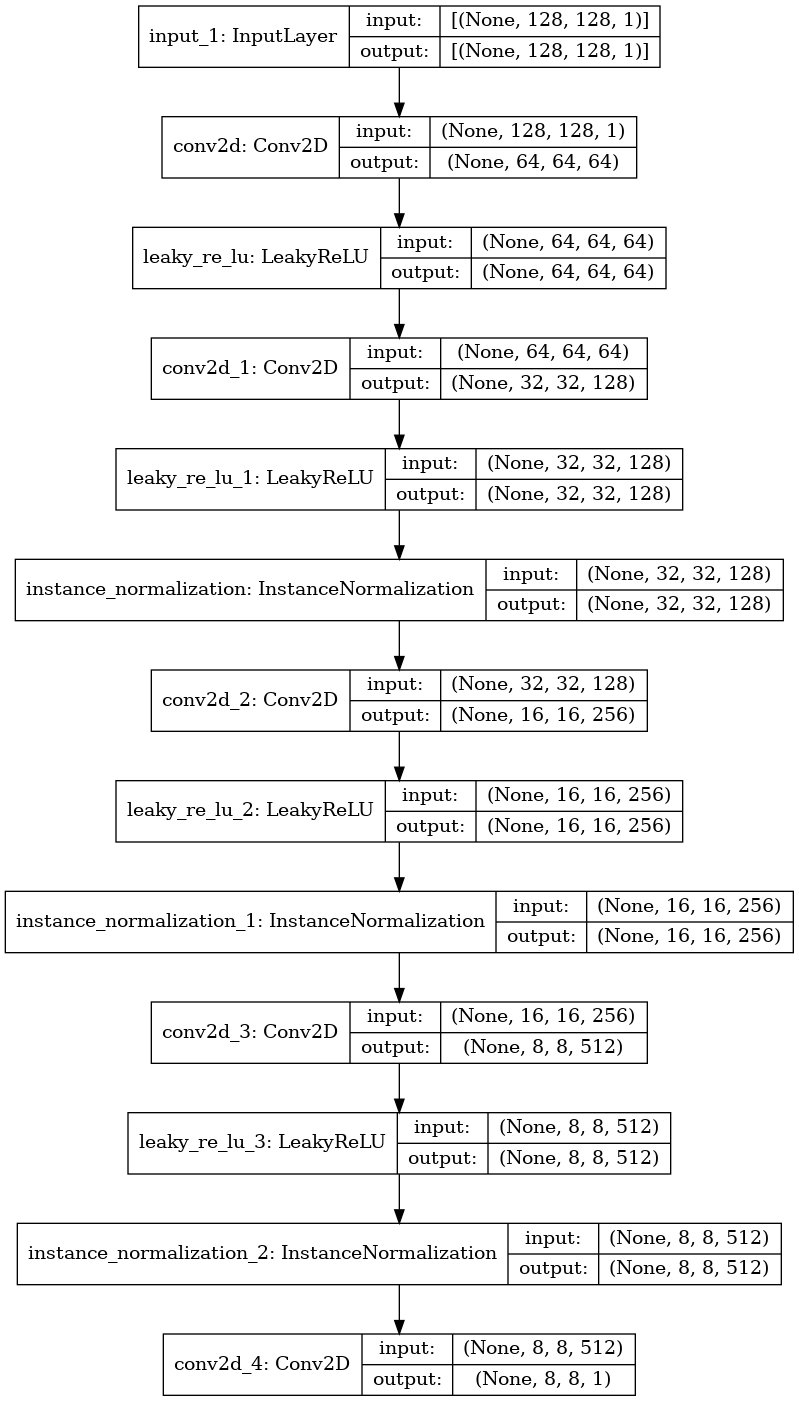

In [27]:
Image(model_to_dot(cg.d_A, show_shapes=True).create_png())

In [28]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  rotation_range = 10, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.7, 1.3],
                  horizontal_flip = True, 
                  vertical_flip = False,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function=lambda x: x/255.0)

core_idg = ImageDataGenerator(**dg_args)

In [30]:
from sklearn.model_selection import train_test_split

class loader_class():
    def __init__(self, a_df, b_df, goal_size):
        self.goal_size = goal_size
        self.a_df = a_df
        self.b_df = b_df
        self._a_gen = None
        self._b_gen = None
        self.n_batches = 0

    def _make_gen(self, batch_size, use_cached):
        if use_cached and (self._a_gen is not None):
            return self._a_gen, self._b_gen
        
            
        a_gen = core_idg.flow_from_dataframe(self.a_df,
                                               x_col='image_path',
                                               y_col='image_path',
                                               class_mode=None,
                                               target_size=self.goal_size,
                                               color_mode='grayscale',
                                               batch_size=batch_size)
        b_gen = core_idg.flow_from_dataframe(self.b_df,
                                                 x_col='image_path',
                                                 y_col='image_path',
                                                 class_mode=None,
                                                 target_size=self.goal_size,
                                                 color_mode='grayscale',
                                                 batch_size=batch_size)
        if use_cached:
            self._a_gen = a_gen
            self._b_gen = b_gen
        
        return a_gen, b_gen

    def load_batch(self, batch_size):
        a_gen, b_gen = self._make_gen(batch_size, use_cached=False)
        for a_x, b_x in zip(a_gen, b_gen):
            if (a_x.shape[0]==batch_size) and (b_x.shape[0]==batch_size):
                yield a_x, b_x
            else:
                yield None, None

    def load_data(self, domain="A", batch_size=1, is_testing=False):
        a_gen, b_gen = self._make_gen(batch_size, use_cached=True)
        if domain == "A":
            return next(a_gen)
        elif domain == "B":
            return next(b_gen)
        else:
            raise ValueError("Unknown domain")

loader_obj = loader_class(
    a_df=images_a_df, 
    b_df=images_b_df, 
    goal_size=IMAGE_SIZE
)
loader_obj.load_data(domain="A", batch_size=1, is_testing=True).shape

Found 1600 validated image filenames.
Found 1408 validated image filenames.


(1, 128, 128, 1)

In [31]:
# sanity check on the tool
for _, (a, b) in zip(range(2), loader_obj.load_batch(8)):
    print(a.shape, b.shape)

Found 1600 validated image filenames.
Found 1408 validated image filenames.
(8, 128, 128, 1) (8, 128, 128, 1)
(8, 128, 128, 1) (8, 128, 128, 1)


2022-01-21 07:08:16.710343: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-21 07:08:17.794130: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


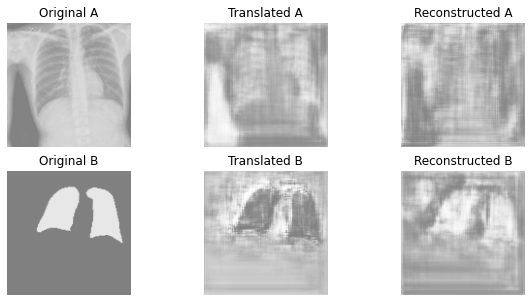

In [32]:
def sample_images(cyc_gan, data_loader, epoch, batch_i):
    plt.close('all')
    r, c = 2, 3

    imgs_A = data_loader.load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = data_loader.load_data(domain="B", batch_size=1, is_testing=True)

    # Translate images to the other domain
    fake_B = cyc_gan.g_AB.predict(imgs_A)
    fake_A = cyc_gan.g_BA.predict(imgs_B)
    # Translate back to original domain
    reconstr_A = cyc_gan.g_BA.predict(fake_B)
    reconstr_B = cyc_gan.g_AB.predict(fake_A)

    gen_imgs = [imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B]

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c, figsize=(10, 5))
    cnt = 0
    for i in range(r):
        for j in range(c):
            c_img = np.clip(0.5 * gen_imgs[cnt][0]+0.5, 0, 1)
            axs[i,j].imshow(c_img.squeeze(), cmap='gray', vmin=0, vmax=1)
            axs[i, j].set_title('{} {}'.format(titles[j], 'A' if i==0 else 'B'))
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("{:03d}_{:03d}.png".format(epoch, batch_i))
sample_images(cg, loader_obj, 0, 0)

In [33]:
BATCH_SIZE = 64
EPOCHS = 30

In [ ]:
start_time = datetime.datetime.now()

# Adversarial loss ground truths
valid = np.ones((BATCH_SIZE,) + cg.disc_patch)
fake = np.zeros((BATCH_SIZE,) + cg.disc_patch)

for epoch in tqdm_notebook(range(EPOCHS), desc='Epochs'):
    for batch_i, (imgs_A, imgs_B) in tqdm_notebook(enumerate(loader_obj.load_batch(BATCH_SIZE)), desc='Batch'):
        #  Train Discriminators
        if imgs_A is None:
            break
        # Translate images to opposite domain
        fake_B = cg.g_AB.predict(imgs_A)
        fake_A = cg.g_BA.predict(imgs_B)

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = cg.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = cg.d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = cg.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = cg.d_B.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)
        
        #  Train Generators
        # Train the generators
        g_loss = cg.combined.train_on_batch([imgs_A, imgs_B],
                                            [valid, valid,
                                                imgs_A, imgs_B,
                                                imgs_A, imgs_B])

        elapsed_time = datetime.datetime.now() - start_time
    
    # Plot the progress at each epoch
    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                            % ( epoch, EPOCHS,
                                                                batch_i, loader_obj.n_batches,
                                                                d_loss[0], 100*d_loss[1],
                                                                g_loss[0],
                                                                np.mean(g_loss[1:3]),
                                                                np.mean(g_loss[3:5]),
                                                                np.mean(g_loss[5:6]),
                                                                elapsed_time))
    
    clear_output()
    sample_images(cg, loader_obj, epoch, batch_i)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Batch: 0it [00:00, ?it/s]

Found 1600 validated image filenames.
Found 1408 validated image filenames.
